# Analysis of IMB

This notebook performs data analysis of the csv files created by running the IMB benchmark

In [1]:
import csv

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

In [3]:
results = {
    "Cloud_IMB":[],
    "SCARF_IMB":[]
}

for dataName in results:
    with open("../" + dataName + "/out.csv", "r") as fHandle:
        reader = csv.reader(fHandle)  # create an iterator over each row
        headers = next(reader) # the headers are the first line
        latencyIndex = headers.index("Latency")  #
        bandwidthIndex = headers.index("0")  # after hear, all are the bandwidths
        thisMessageSizes = [int(el) for el in headers[bandwidthIndex + 1:]]
        try:
            if messageSizes != [int(el) for el in headers[bandwidthIndex + 1:]]:
                raise ValueError("Different message sizes")
        except NameError: # if messageSizes hasn't been set yet
            messageSizes = thisMessageSizes
        for row in reader:
            thisRow = dict((header, row[index]) for index, header in enumerate(headers))
            thisRow["Bandwidths"] = [float(el) for el in row[bandwidthIndex + 1:]]
            thisRow["maxBandwidths"] = max(thisRow["Bandwidths"])
            thisRow["meanBandwidths"] = sum(thisRow["Bandwidths"]) / len(thisRow["Bandwidths"])
            results[dataName].append(thisRow)
print("Message Sizes:")
print(messageSizes)
print()
for dataName in results:
    print(dataName)
    print("1st latency:        {}".format(results[dataName][0]["Latency"]))
    print("max bandwidth:      {}".format(max(test["maxBandwidths"] for test in results[dataName])))
    print("1st bandwidths(10): {}".format(results[dataName][0]["Bandwidths"][0:10]))
    print("Headers:            {}".format(results[dataName][0].keys()))
    print()
        

Message Sizes:
[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]

SCARF_IMB
1st latency:        0.23
max bandwidth:      9149.72
1st bandwidths(10): [3.98, 7.96, 15.96, 31.86, 63.71, 126.61, 261.36, 311.81, 597.61, 1037.75]
Headers:            dict_keys(['Max Processes', 'Host Groups', 'Max Swap (MB)', 'Max Threads', 'Run time (sec.)', '262144', '1024', '4194304', 'maxBandwidths', '1048576', '131072', 'File Name', 'Protocols Seen', '16384', 'Average Memory (MB)', '32768', 'Hosts Used', '65536', '32', '8', '2', 'Exclusive', 'Latency', '2048', 'CPU time (sec.)', '16', 'Bandwidths', '4096', 'Number of Hosts', '1', 'Total Requested Memory (MB)', '0', '16777216', '8388608', '4', 'meanBandwidths', '128', '256', '512', '524288', '64', '2097152', 'Max Memory (MB)', 'Delta Memory (MB)', 'Turnaround time (sec.)', '8192'])

Cloud_IMB
1st latency:        0.27
max bandwidth:      7717.49
1st ban

In [4]:
import datetime

# Do cloud dates:
for result in results["Cloud_IMB"]:
    result["Date Run"] = datetime.datetime.strptime(result["File Name"], "%Y%m%d_%H%M%S.out")


['SHM', 'SHM-IBV', 'SHM-TCP']


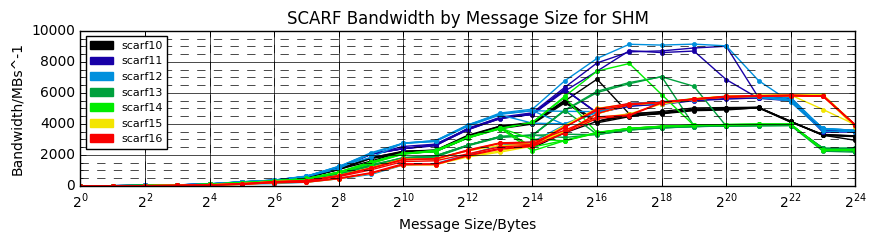

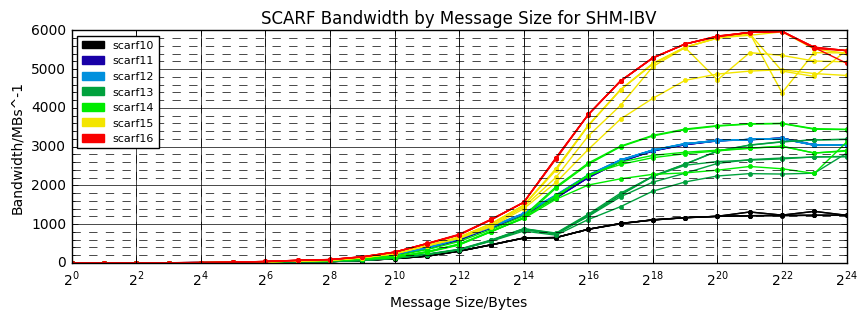

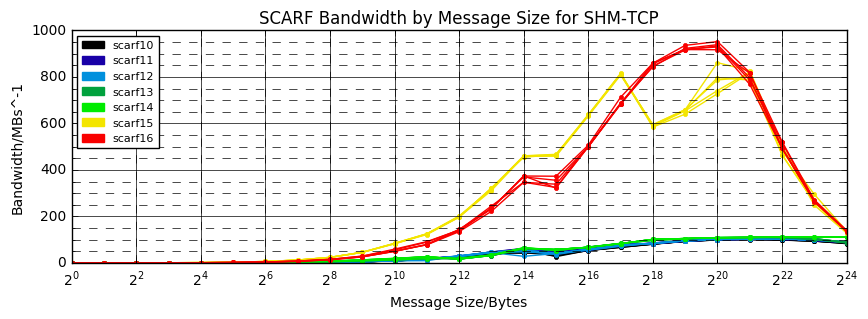

In [9]:
def plotScarfBandwidth():
    protocols = sorted(set(row["Protocols Seen"] for row in results["SCARF_IMB"]))
    print(protocols)
    for prot in protocols:
        res = [row for row in results["SCARF_IMB"] if row["Protocols Seen"] == prot]
        hostgroups = sorted(set(row["Host Groups"] for row in res))
        clrMap = plt.get_cmap("nipy_spectral")
        legendHandles = []
        for index, hostgroup in enumerate(hostgroups):
            clr = clrMap(index / len(hostgroups))
            legendHandles.append(mpatches.Patch(color=clr, label=hostgroup.split("-")[0]))
        for index, row in enumerate(sorted(res, key=lambda el: el["File Name"])):
            band = row["Bandwidths"]
            clr = clrMap(hostgroups.index(row["Host Groups"]) / len(hostgroups))
            clr = (clr[0], clr[1], clr[2], 1)
            plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
            nodeNumbers = ",".join(re.findall("cn\d+", row["Hosts Used"]))
            # legendHandles.append(mpatches.Patch(color=clr, label=nodeNumbers))
        plt.legend(handles=legendHandles, loc=2, ncol=1, fontsize=8)
        plt.rcParams["figure.figsize"] = (10, 3)
        plt.xscale("log", basex=2)
        plt.title("SCARF Bandwidth by Message Size for {}".format(prot))
        plt.xlabel("Message Size/Bytes")
        plt.ylabel("Bandwidth/MBs^-1")
        plt.grid(True, which="minor", linestyle="--")
        plt.grid(True, which="major", linestyle="-")
        plt.minorticks_on()
        plt.show()

plotScarfBandwidth()


['1', '2']


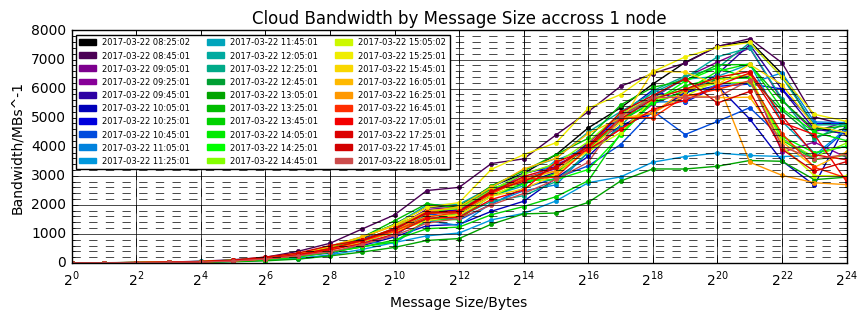

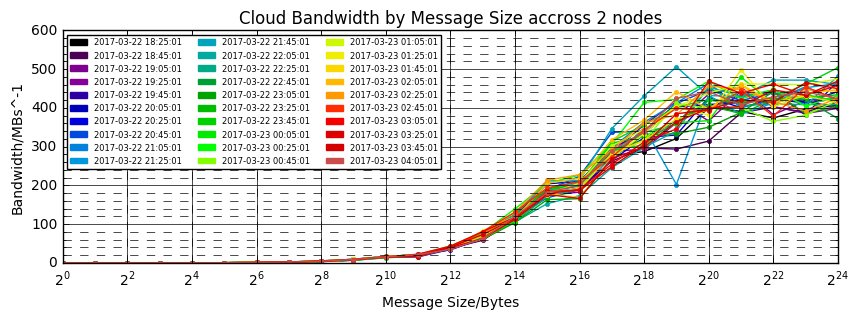

In [10]:
def plotCloudBandwidth():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    print(numHostsSet)
    for numHosts in numHostsSet:
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        clrMap = plt.get_cmap("nipy_spectral")
        legendHandles = []
        for index, row in enumerate(sorted(res, key=lambda el: el["Date Run"])):  # sort by date run
            band = row["Bandwidths"]
            clr = clrMap(index / len(res))
            clr = (clr[0], clr[1], clr[2], 1)
            plt.plot(messageSizes, band, color=clr, marker=".", linestyle="-")
            legendHandles.append(mpatches.Patch(color=clr, label=row["Date Run"]))
        plt.legend(handles=legendHandles, loc=2, ncol=3, fontsize=6)
        plt.rcParams["figure.figsize"] = (10, 3)
        plt.xscale("log", basex=2)
        titleEnd = "1 node" if numHosts == "1" else "{} nodes".format(numHosts)
        plt.title("Cloud Bandwidth by Message Size accross " + titleEnd)
        plt.xlabel("Message Size/Bytes")
        plt.ylabel("Bandwidth/MBs^-1")
        plt.grid(True, which="minor", linestyle="--")
        plt.grid(True, which="major", linestyle="-")
        plt.minorticks_on()
        plt.show()

plotCloudBandwidth()

['1', '2']


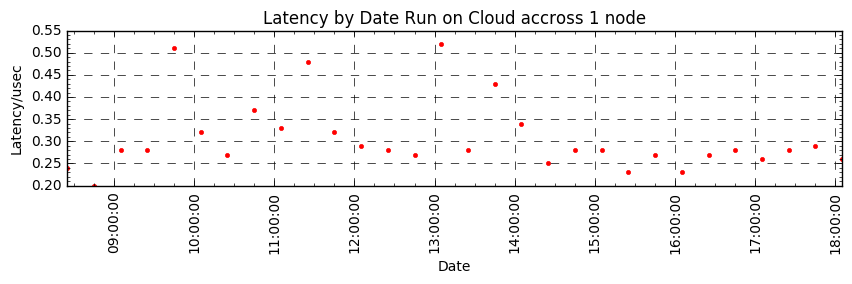

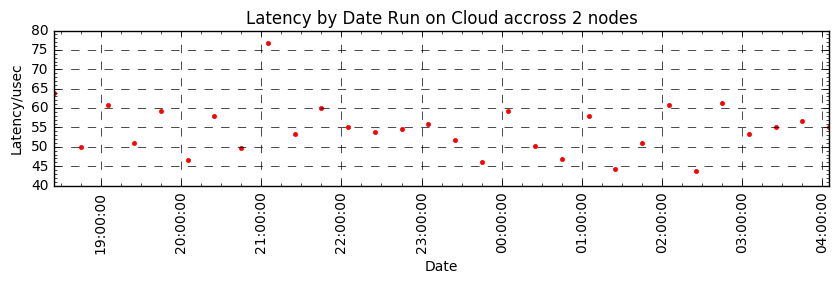

In [12]:
def plotCloudLatencies():
    numHostsSet = sorted(set(row['Number of Hosts'] for row in results["Cloud_IMB"]))
    print(numHostsSet)
    
    for index, numHosts in enumerate(numHostsSet):
        res = [row for row in results["Cloud_IMB"] if row['Number of Hosts'] == numHosts]
        plt.plot([row["Date Run"] for row in res], 
                 [row["Latency"] for row in res], "r.")
        plt.xticks(rotation='vertical')
        plt.rcParams["figure.figsize"] = (10,2)
        titleEnd = "1 node" if numHosts == "1" else "{} nodes".format(numHosts)
        plt.title("Latency by Date Run on Cloud accross " + titleEnd)
        plt.ylabel("Latency/usec")
        plt.xlabel("Date")
        #plt.grid(True, which="minor", linestyle="-")
        plt.grid(True, which="major", linestyle="--")
        plt.minorticks_on()
        plt.show()

plotCloudLatencies()

In [8]:
def plotLatenciesAndMaxBandwidth():
    fig, ax1 = plt.subplots(figsize=plotSize)
    ax1.plot(datesRun[start:end], latencies[start:end], 'r.')
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel("Latency/usec", color='r')
    ax1.tick_params('y', colors='r')

    ax2 = ax1.twinx()
    ax2.plot(datesRun[start:end], maxBandwidths[start:end], 'g.')
    # ax2.plot(datesRun[start:end], meanBandwidths[start:end], 'b.')
    ax2.set_ylabel("Bandwidth/MBs^-1", color='g')
    ax2.tick_params('y', colors='g')

    plt.title("Latency and Max Bandwidth by Date Run")

    ax1.grid(True, which="minor", linestyle="--")
    ax1.grid(True, which="major", linestyle="-")

    plt.show()
    


plotLatenciesAndMaxBandwidth(0, len(datesRun))

NameError: name 'datesRun' is not defined